# Demand Prediction : Shared Bikes

### Context

BoomMBikes, a US bike-sharing provider, has faced revenue declines due to the pandemic. To recover, they aim to develop a strategic business plan post-lockdown. The company has enlisted a consulting firm to analyze factors influencing shared bike demand in the American market. They seek to identify significant variables predicting demand and assess how well these variables explain bike demands. Using data from meteorological surveys and lifestyle information, BoomBikes aims to position itself for success in the anticipated post-quarantine surge in bike usage.

#### Problem Statement:



#### Business Goal

- Prepare a ML Model to predict demand for shared bikes with the available independent variables
- Establish a relationship to predict how demands vary with different features
- So that the business leaders can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. 

#### Objective/s
- Find out which variables are significant in predicting the demand for shared bikes. 
- How well those variables describe the bike demands

# Summary of the steps 

- Reading, understanding and visualizing data
- Preparing the data for modeling i.e 
    - train_test split
    - rescaling 
- Training the model 
- Residual analysis
- Prediction and evaluation on the test set

## Step 1: Reading and Understanding the Data

Let us first import NumPy and Pandas and read the Bike Sharing dataset

In [20]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [22]:
bikesharing = pd.read_csv("Bike Sharing dataset.csv")

In [23]:
# Check the head of the dataset
bikesharing.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


Inspect the various aspects of the bikesharing dataframe

#### Data dictionary inputs 

- instant: record index
- dteday : date
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2018, 1:2019)
- mnth : month ( 1 to 12)
- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : temperature in Celsius
- atemp: feeling temperature in Celsius
- hum: humidity
- windspeed: wind speed
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [24]:
bikesharing.shape

(730, 16)

In [25]:
bikesharing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


### Observations
- Since our objective is to predict demand, from the data set it is safe to conclude that the target variable (or dependent variable) is 'cnt'. We are going to treat others as independent variables in our analysis. 
- The dataset doesn't contain any null or na vaules. 

Action Items
- Remvoe 'instant' column - not required in the analyis
- Remove 'dteday' since month, day (weekend or weekday), year has already been extracted and available in other columns
- Identify the categorical variables with the help of data dictionary
    - Columns having categorical variables are 'season', 


In [26]:
# Remove 'instant' and 'dteday' columns from the data set

bikesharing = bikesharing.drop(['instant', 'dteday'], axis = 1)

# define a list columns containing categorical variables

categorical_col = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit' ]

# change data type to object for the following columns

bikesharing[categorical_col] = bikesharing[categorical_col].astype('object')


In [27]:
# get te statistical summary of all the numerical variables
bikesharing.describe().round(2)

,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.00,730.00,730.00,730.00,730.00,730.00,730.00
mean,20.32,23.73,62.77,12.76,849.25,3658.76,4508.01
std,7.51,8.15,14.24,5.20,686.48,1559.76,1936.01
min,2.42,3.95,0.00,1.50,2.00,20.00,22.00
25%,13.81,16.89,52.00,9.04,316.25,2502.25,3169.75
50%,20.47,24.37,62.62,12.13,717.00,3664.50,4548.50
75%,26.88,30.45,72.99,15.63,1096.50,4783.25,5966.00
max,35.33,42.04,97.25,34.00,3410.00,6946.00,8714.00


## Step 2: Visualising the Data

The objective of this section is to 
- find out whether there is a strong association with outcome variable or not 
- find out obvious mulicollineariry if any exists

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Visualising Numeric Variables

Let's make a pairplot of all the numeric variables

In [29]:
# bikesharing.columns- get the columns and plot in the scatter plot
print (bikesharing.columns)
print (categorical_col)

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt'],
      dtype='object')
['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']


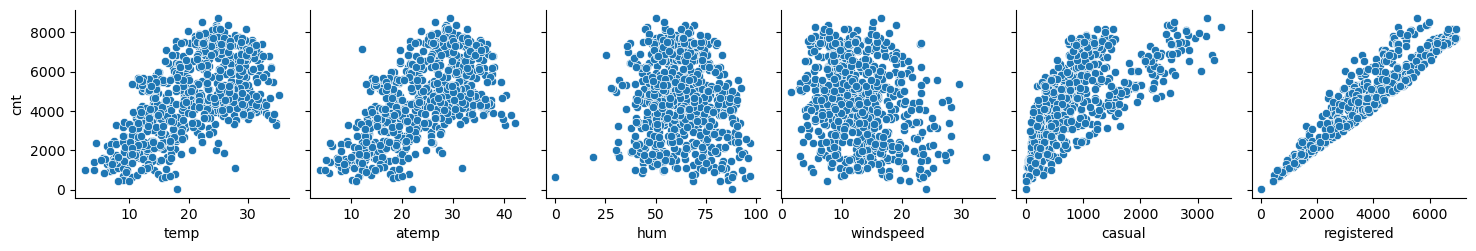

In [30]:
# sns.pairplot(bikesharing)

sns.pairplot(bikesharing, x_vars=[ 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered'], y_vars='cnt')

plt.show()

### Observations
- As 'temp', 'atemp', 'casual' or 'registered' values increases in the x-axis the corresponding value in the y-axis(cnt) also increases.
- There is definitely a relationship between these variables and the target variable  ('cnt')
- It seems that there is no definite relationship exist between 'hum', 'windspeed' with 'cnt'. 


#### Visualising Categorical Variables

As we have noticed, there are a few categorical variables as well. Let's make a boxplot for some of these variables.
['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']


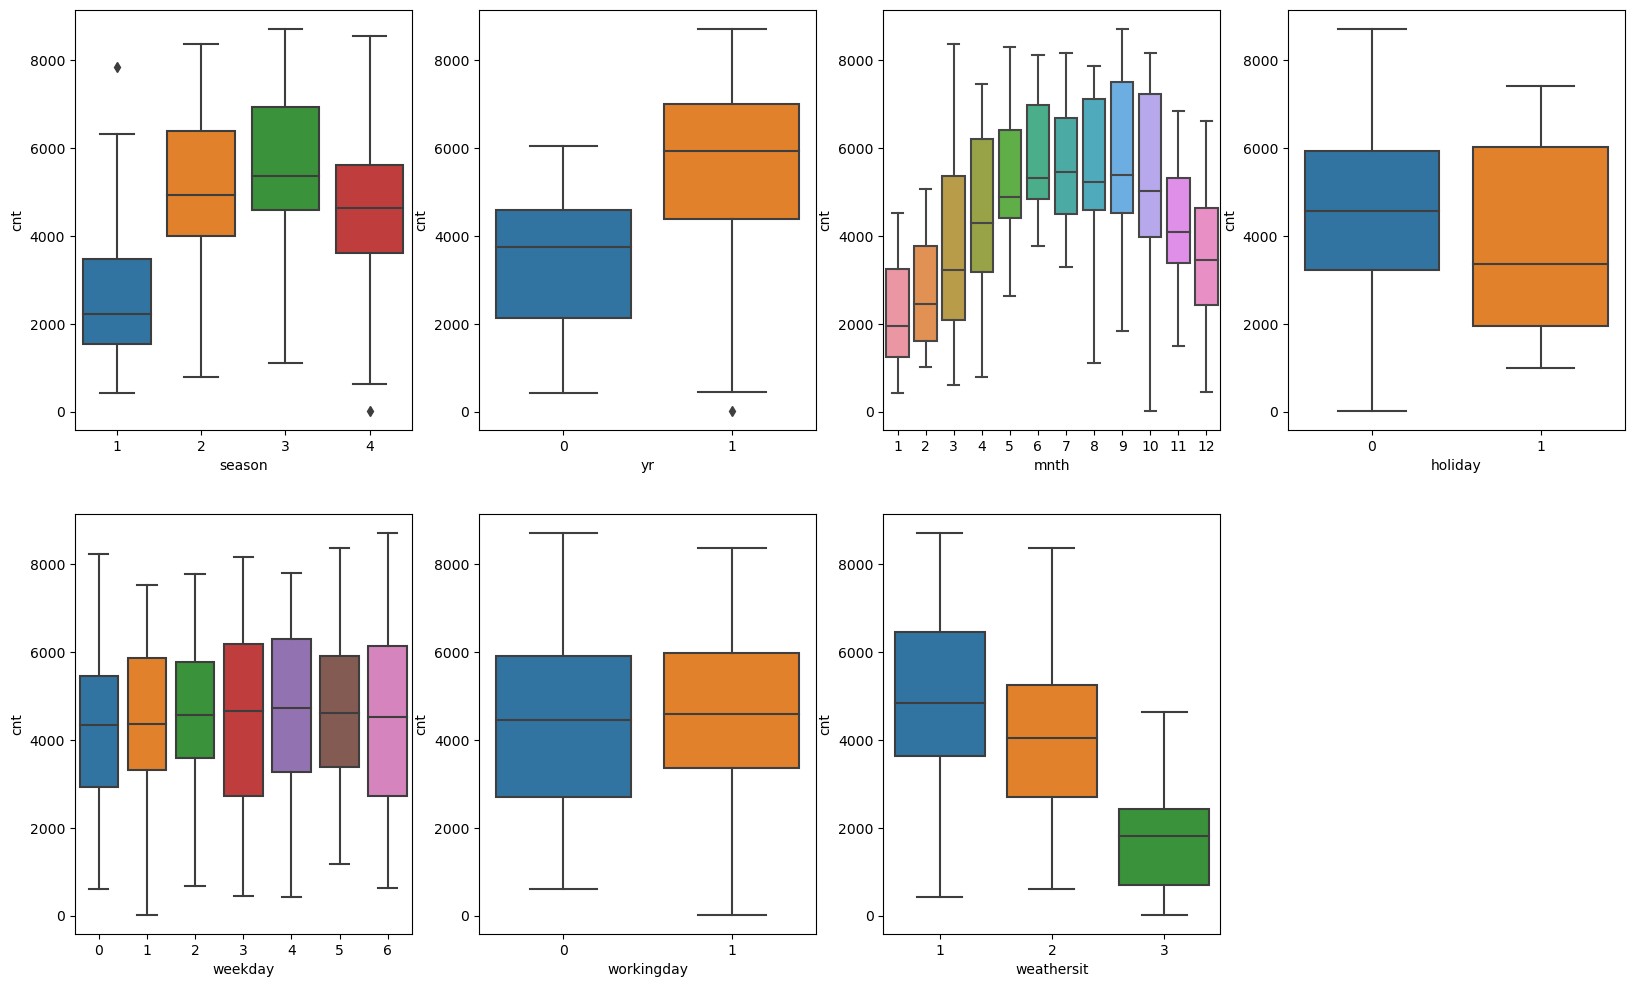

In [31]:
plt.figure(figsize=(20, 12))
plt.subplot(2,4,1)
sns.boxplot(x = 'season', y = 'cnt', data = bikesharing)
plt.subplot(2,4,2)
sns.boxplot(x = 'yr', y = 'cnt', data = bikesharing)
plt.subplot(2,4,3)
sns.boxplot(x = 'mnth', y = 'cnt', data = bikesharing)
plt.subplot(2,4,4)
sns.boxplot(x = 'holiday', y = 'cnt', data = bikesharing)
plt.subplot(2,4,5)
sns.boxplot(x = 'weekday', y = 'cnt', data = bikesharing)
plt.subplot(2,4,6)
sns.boxplot(x = 'workingday', y = 'cnt', data = bikesharing)
plt.subplot(2,4,7)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bikesharing)
plt.show()

We can also visualise some of these categorical features parallely by using the `hue` argument. Below is the plot for `workingday` with `weathersit` as the hue.

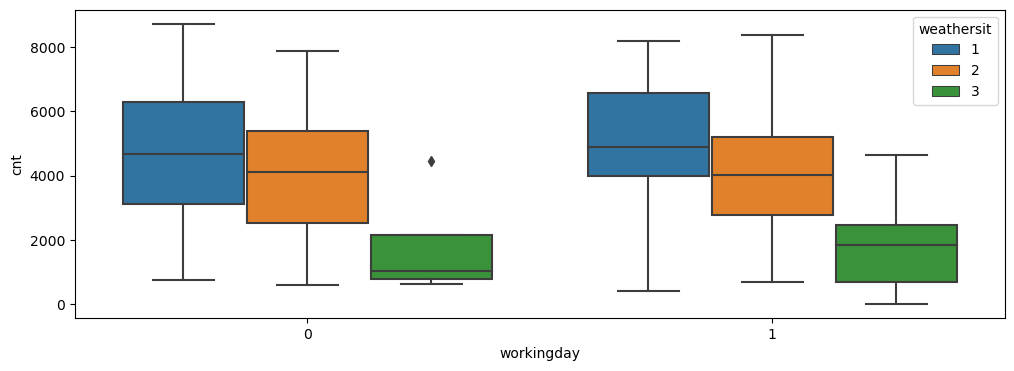

In [32]:
plt.figure(figsize = (12, 4))
sns.boxplot(x = 'workingday', y = 'cnt', hue = 'weathersit', data = bikesharing)
plt.show()


### Observation/s

- On working days (1 i.e neither holiday nor weekend) even if the weather condition is light snow (3), the median is much higher than non-working days (0)

## Step 3: Data Preparation

- We can see that our dataset don't have columns with values as 'Yes' or 'No'or any other categorical values by names. All categorical varialbes have been converted into numerical digits. So we don't have to do any encoding but we need to convert other categorical variables to dummy variables. 

- Encoding
    - Converting binary variables to 0/1. -  Not required
    - Other categorical variables to dummy vars
- Split into train and test 
- Rescaling of variables

### Encoding: Convert categorical variables in to dummy Variables

Variables and categorical levels 

- season      - 4 levels 
- yr          - 2 levels
- mnth        - 12 levels
- holiday     - 2 levels
- weekday     - 7 levles
- working day - 2 levels
- weathersit  - 4 levels 


These variables have multiple levels. We will encode these variables first and then convert these levels into dummy variables. 

- Encoding 'season'
    - 1:spring
    - 2:summer
    - 3:fall
    - 4:winter
- weathersit
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    
- workingday
    - 1: if day is neither weekend nor holiday is 1,
    - 0: non-workingday 
- year
    - 0: 2018
    - 1: 2019
- Month
    - 1:Jan
    - 2:Feb
    - 3:Mar
    - 4:Apr
    - 5:May
    - 6:June
    - 7:July
    - 8:Aug
    - 9:Sep
    - 10:Oct
    - 11:Nov
    - 12:Dec

- WeekDay:
    - 0:Mon
    - 1:Tue
    - 2:Wed
    - 3:Thu
    - 4:Fri
    - 5:Sat
    - 6:Sun
- holiday: 
    - 1: holiday
    - 0: not_a_holiday

In [33]:
# encoding season
codes = {1:'spring',2:'summer',3:'fall',4:'winter'}
bikesharing['season'] = bikesharing['season'].map(codes)

# encoding weathersit
codes = {1:'Clear',2:'Mist',3:'Light Snow',4:'Heavy Rain'}
bikesharing['weathersit'] = bikesharing['weathersit'].map(codes)

# encoding workingday
codes = {1:'working_day',0:'Non_workingday'}
bikesharing['workingday'] = bikesharing['workingday'].map(codes)

# encoding year
codes = {1:2019, 0:2018}
bikesharing['yr'] = bikesharing['yr'].map(codes)

# encoding Month
codes = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'June',7:'July',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
bikesharing['mnth'] = bikesharing['mnth'].map(codes)
                                            
# encoding WeekDay
codes = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
bikesharing['weekday'] = bikesharing['weekday'].map(codes)

# encoding Holiday
codes = {0:'not_a_holiday',1:'holiday'}
bikesharing['holiday'] = bikesharing['holiday'].map(codes)

bikesharing.head()


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,spring,2018,Jan,not_a_holiday,Sun,Non_workingday,Mist,14.110847,18.18125,80.5833,10.749882,331,654,985
1,spring,2018,Jan,not_a_holiday,Mon,Non_workingday,Mist,14.902598,17.68695,69.6087,16.652113,131,670,801
2,spring,2018,Jan,not_a_holiday,Tue,working_day,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,spring,2018,Jan,not_a_holiday,Wed,working_day,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,spring,2018,Jan,not_a_holiday,Thu,working_day,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [34]:
# Let's get dummy variables and drop the first column from dummy_var df using 'drop_first = True'

dummy_var = pd.get_dummies(bikesharing[categorical_col], drop_first = True)
dummy_var.head(5)

,yr,season_spring,season_summer,season_winter,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,mnth_July,mnth_June,...,holiday_not_a_holiday,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,workingday_working_day,weathersit_Light Snow,weathersit_Mist
0,2018,1,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
1,2018,1,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,1
2,2018,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,1,0,0
3,2018,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,1,0,0
4,2018,1,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0


In [35]:
# Add the results to the original housing dataframe

bikesharing = pd.concat([bikesharing, dummy_var], axis = 1)

In [36]:
# Now let's see the head of our dataframe.

bikesharing.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,holiday_not_a_holiday,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,workingday_working_day,weathersit_Light Snow,weathersit_Mist
0,spring,2018,Jan,not_a_holiday,Sun,Non_workingday,Mist,14.110847,18.18125,80.5833,...,1,0,0,1,0,0,0,0,0,1
1,spring,2018,Jan,not_a_holiday,Mon,Non_workingday,Mist,14.902598,17.68695,69.6087,...,1,1,0,0,0,0,0,0,0,1
2,spring,2018,Jan,not_a_holiday,Tue,working_day,Clear,8.050924,9.47025,43.7273,...,1,0,0,0,0,1,0,1,0,0
3,spring,2018,Jan,not_a_holiday,Wed,working_day,Clear,8.200000,10.60610,59.0435,...,1,0,0,0,0,0,1,1,0,0
4,spring,2018,Jan,not_a_holiday,Thu,working_day,Clear,9.305237,11.46350,43.6957,...,1,0,0,0,1,0,0,1,0,0


In [37]:
# Drop categorical_col as we have created the dummies for it

bikesharing.drop(categorical_col, axis = 1, inplace = True)

In [38]:
bikesharing.head()

,temp,atemp,hum,windspeed,casual,registered,cnt,season_spring,season_summer,season_winter,...,holiday_not_a_holiday,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,workingday_working_day,weathersit_Light Snow,weathersit_Mist
0,14.110847,18.18125,80.5833,10.749882,331,654,985,1,0,0,...,1,0,0,1,0,0,0,0,0,1
1,14.902598,17.68695,69.6087,16.652113,131,670,801,1,0,0,...,1,1,0,0,0,0,0,0,0,1
2,8.050924,9.47025,43.7273,16.636703,120,1229,1349,1,0,0,...,1,0,0,0,0,1,0,1,0,0
3,8.200000,10.60610,59.0435,10.739832,108,1454,1562,1,0,0,...,1,0,0,0,0,0,1,1,0,0
4,9.305237,11.46350,43.6957,12.522300,82,1518,1600,1,0,0,...,1,0,0,0,1,0,0,1,0,0


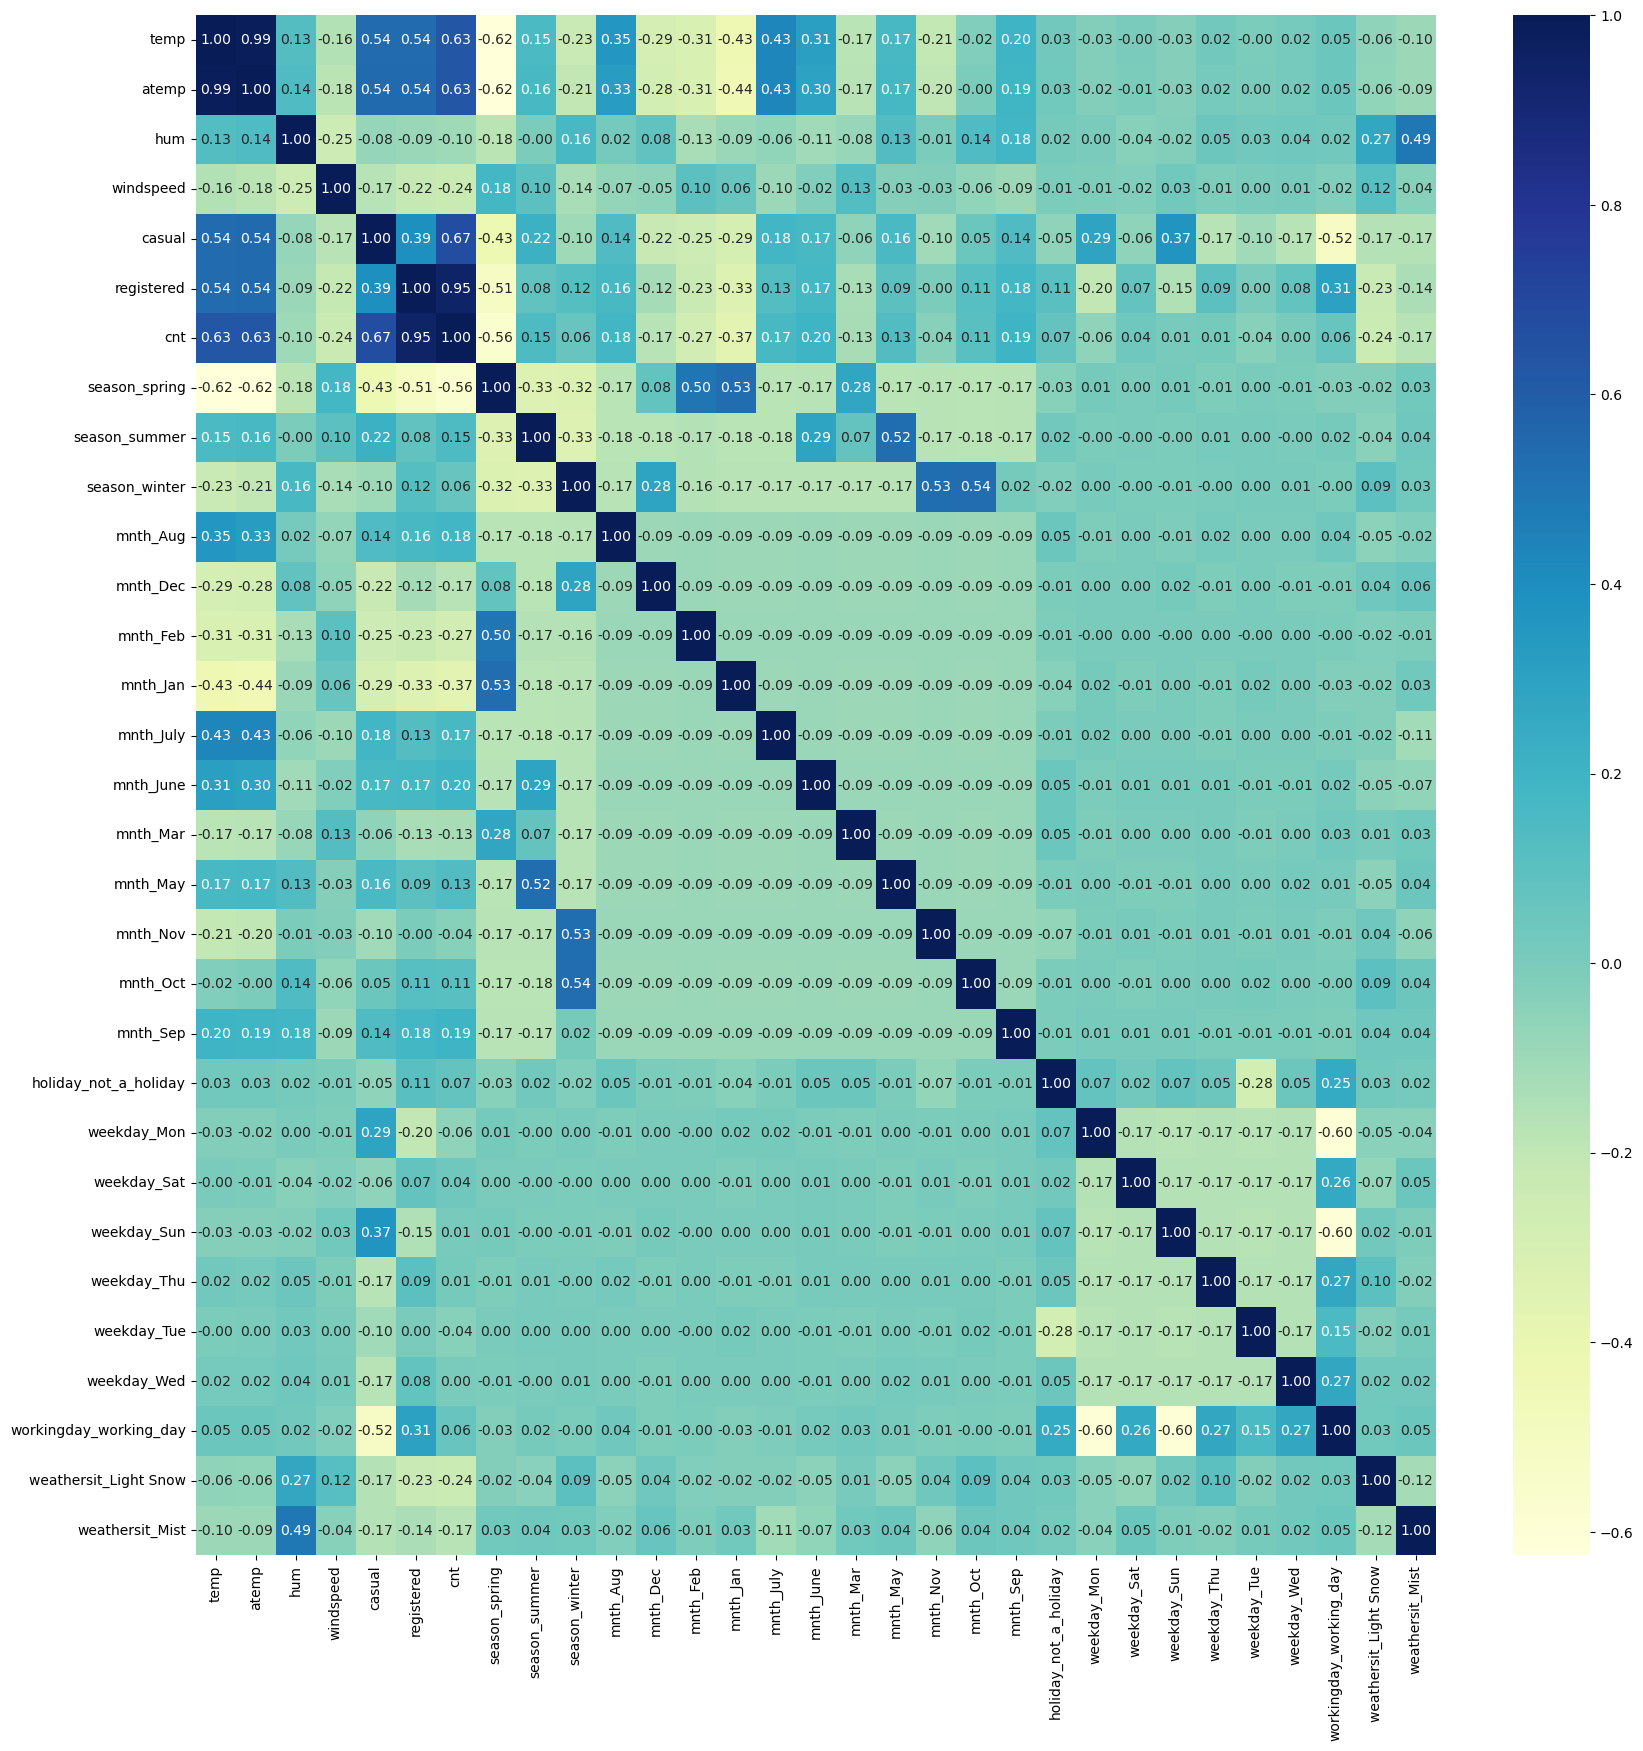

In [58]:
corr_matrix = bikesharing.corr()

plt.figure(figsize=(20, 20))

# Create a heatmap using seaborn
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt=".2f")

# Show the plot
plt.show()


#### Get rid of the highly correlated values
- since it will be difficult to interprete multicollinearity using headmap, we will take help of VIF
- We will be following this rough guideline to eliminate multi colinearity
    - VIF = 1: No correlation between the independent variable and the other variables.
    - VIF < 5: Generally considered low and acceptable.
    - 5 < VIF < 10: Indicates a moderate correlation that may be a concern, depending on the context.
    - VIF > 10: High correlation and may indicate a severe multicollinearity problem.
- We will drop one variable after another and check VIF and repeat this process till we get VIF<7  for all variables


In [842]:
# Calculate the VIFs for the features and exclude the dependent variable 
from statsmodels.stats.outliers_influence import variance_inflation_factor

drop_cnt = bikesharing.drop('cnt', axis=1)

vif = pd.DataFrame()
X = drop_cnt
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
20,holiday_not_a_holiday,inf
21,weekday_Mon,inf
23,weekday_Sun,inf
27,workingday_working_day,inf
0,temp,679.01
1,atemp,657.69
2,hum,40.83
5,registered,17.76
6,season_spring,12.30
8,season_winter,10.90


In [843]:
# dropping 'holiday_not_a_holiday' and running VIF again 

drop = bikesharing.drop(['cnt','holiday_not_a_holiday'] , axis=1)

vif = pd.DataFrame()
X = drop
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,temp,679.01
1,atemp,657.69
2,hum,40.83
26,workingday_working_day,25.10
5,registered,17.76
6,season_spring,12.30
8,season_winter,10.90
4,casual,10.31
3,windspeed,8.21
7,season_summer,8.03


In [844]:
# repeating the same process
# dropping 'temp' and running VIF again

drop = bikesharing.drop(['cnt','holiday_not_a_holiday', 'temp'] , axis=1)

vif = pd.DataFrame()
X = drop
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


,Features,VIF
0,atemp,55.57
1,hum,40.69
25,workingday_working_day,25.03
4,registered,17.73
5,season_spring,12.29
7,season_winter,10.89
3,casual,10.23
6,season_summer,8.00
2,windspeed,7.69
21,weekday_Sun,6.23


In [845]:
# repeating the same process
# dropping 'atemp' and running VIF again

drop = bikesharing.drop(['cnt','holiday_not_a_holiday', 'temp', 'atemp'] , axis=1)

vif = pd.DataFrame()
X = drop
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif



,Features,VIF
0,hum,30.75
24,workingday_working_day,24.12
3,registered,16.86
4,season_spring,12.26
6,season_winter,10.89
2,casual,9.37
5,season_summer,7.96
1,windspeed,7.25
20,weekday_Sun,6.20
16,mnth_Oct,6.13


In [846]:
# repeating the same process
# dropping 'hum' and running VIF again

drop = bikesharing.drop(['cnt','holiday_not_a_holiday', 'temp', 'atemp','hum'] , axis=1)

vif = pd.DataFrame()
X = drop
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
23,workingday_working_day,21.68
2,registered,16.86
3,season_spring,11.95
5,season_winter,10.81
1,casual,9.31
0,windspeed,7.18
4,season_summer,7.06
15,mnth_Oct,5.60
19,weekday_Sun,5.60
17,weekday_Mon,5.36


In [847]:
# repeating the same process
# dropping 'workingday_working_day' and running VIF again

drop = bikesharing.drop(['cnt','holiday_not_a_holiday', 'temp', 'atemp','hum', 'workingday_working_day'] , axis=1)

vif = pd.DataFrame()
X = drop
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


,Features,VIF
2,registered,13.61
3,season_spring,11.17
5,season_winter,10.62
1,casual,8.78
0,windspeed,6.90
4,season_summer,5.52
15,mnth_Oct,5.24
14,mnth_Nov,4.88
9,mnth_Jan,4.71
8,mnth_Feb,4.38


In [848]:
# repeating the same process
# dropping 'registered' and running VIF again

drop = bikesharing.drop(['cnt','holiday_not_a_holiday', 'temp', 'atemp','hum', 'workingday_working_day', 'registered'] , axis=1)

vif = pd.DataFrame()
X = drop
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,season_spring,11.11
4,season_winter,10.04
0,windspeed,6.76
1,casual,6.50
14,mnth_Oct,5.07
3,season_summer,4.97
13,mnth_Nov,4.76
8,mnth_Jan,4.57
7,mnth_Feb,4.21
6,mnth_Dec,4.00


In [849]:
# repeating the same process
# dropping 'season_spring' and running VIF again

drop = bikesharing.drop(['cnt','holiday_not_a_holiday', 'temp', 'atemp','hum', 'workingday_working_day', 'registered', 'season_spring'] , axis=1)

vif = pd.DataFrame()
X = drop
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


,Features,VIF
3,season_winter,6.93
1,casual,6.46
0,windspeed,6.32
13,mnth_Oct,4.57
12,mnth_Nov,4.25
2,season_summer,3.96
5,mnth_Dec,2.86
17,weekday_Sun,2.68
15,weekday_Mon,2.45
14,mnth_Sep,2.28


In [850]:
# repeating the same process
# dropping 'season_winter' and running VIF again

drop = bikesharing.drop(['cnt','holiday_not_a_holiday', 'temp', 'atemp','hum', 'workingday_working_day', 'registered', 'season_spring', 'season_winter'] , axis=1)

vif = pd.DataFrame()
X = drop
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,casual,6.46
0,windspeed,6.28
2,season_summer,3.95
16,weekday_Sun,2.68
14,weekday_Mon,2.44
3,mnth_Aug,2.11
7,mnth_July,2.11
13,mnth_Sep,2.09
12,mnth_Oct,2.05
18,weekday_Tue,1.93


#### Observation/s

- We have taken VIF<6.5 for all variables
- We can update the data set after with the new dataset after dropping the correlated columns and we can use this to build out modelm

In [851]:
# we should not drop 'cnt' column from the newdata set since it will be our dependent variable in our model
bikesharing = bikesharing.drop(['holiday_not_a_holiday', 'temp', 'atemp','hum', 'workingday_working_day', 'registered', 'season_spring', 'season_winter'] , axis=1)
bikesharing.columns

Index(['windspeed', 'casual', 'cnt', 'season_summer', 'mnth_Aug', 'mnth_Dec',
       'mnth_Feb', 'mnth_Jan', 'mnth_July', 'mnth_June', 'mnth_Mar',
       'mnth_May', 'mnth_Nov', 'mnth_Oct', 'mnth_Sep', 'weekday_Mon',
       'weekday_Sat', 'weekday_Sun', 'weekday_Thu', 'weekday_Tue',
       'weekday_Wed', 'weathersit_Light Snow', 'weathersit_Mist'],
      dtype='object')

## Step 4: Splitting the Data into Training and Testing Sets

In [852]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0) 
#Setting a random seed ensures reproducibility. If you use the same random seed, you'll get the same random numbers every time you run the code
df_train, df_test = train_test_split(bikesharing, train_size = 0.7, test_size = 0.3, random_state = 100)

### Rescaling the Features 

Types of rescaling. 

1. Normalization: (X-Xmin)/(Xmax-Xmin)
2. Standardization: X-mu/sigma

This time, we will use MinMax scaling. Why? Rule of thumb - as a rule of thumb use min max sclaling since it will take care outliars. 

##### Steps 
- initiate an object
- crate a list of numeric variables
- fit on data
    - fit(): learns xmin, xmax
    - transform(): does x-xmin/xmax-xmin
    - fit_transform(): first fit() then transforms


In [853]:
from sklearn.preprocessing import MinMaxScaler

In [854]:
# initiate a object
scaler = MinMaxScaler()

- List of dropped columns due to multicollinearity
    - 'holiday_not_a_holiday', 'temp', 'atemp','hum', 'workingday_working_day', 'registered', 'season_spring'
- List of columns containing numerical values
    - 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt'

In [855]:
# Apply scaler() to all the columns except the 'dropped', categorical' and 'dummy' variables
num_vars = [ 'windspeed', 'casual', 'cnt']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [856]:
df_train.describe()

,windspeed,casual,cnt,season_summer,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,mnth_July,mnth_June,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Light Snow,weathersit_Mist
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.320768,0.254661,0.513620,0.245098,0.096078,0.084314,0.066667,0.088235,0.076471,0.074510,...,0.086275,0.080392,0.143137,0.127451,0.154902,0.158824,0.150980,0.131373,0.029412,0.343137
std,0.169797,0.206011,0.224593,0.430568,0.294988,0.278131,0.249689,0.283915,0.266010,0.262857,...,0.281045,0.272166,0.350557,0.333805,0.362166,0.365870,0.358381,0.338139,0.169124,0.475223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.199179,0.094179,0.356420,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.296763,0.212740,0.518638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.414447,0.327415,0.684710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Observation/s

- the min value is 0 and max value of the numerical columns are 1
- it doesnot make sense to scale the categorical variables. Why? We still can scale those but ultimately it will lead to loss of meaning of the variable and will be treated as numerical values.

# Step-5: Training the Model

Summary of steps
- 


#### Dividing into X and Y sets for the model building

In [857]:
y_train = df_train.pop('cnt')
X_train = df_train

In [858]:
# check 'cnt' is out of the independet variables
X_train.head()

,windspeed,casual,season_summer,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,mnth_July,mnth_June,mnth_Mar,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Light Snow,weathersit_Mist
653,0.300794,0.280402,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
576,0.264686,0.294422,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
426,0.255342,0.290765,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
728,0.663106,0.110332,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
482,0.188475,0.340750,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


#### Building our model

- We will be using the LinearRegression function from SciKit Learn for its compatibility with RFE (which is a utility from sklearn)

In [859]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [860]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=10) # running RFE 10 i.e how many features we want = 10
rfe = rfe.fit(X_train, y_train)

In [861]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('windspeed', False, 8),
 ('casual', True, 1),
 ('season_summer', False, 12),
 ('mnth_Aug', True, 1),
 ('mnth_Dec', False, 2),
 ('mnth_Feb', True, 1),
 ('mnth_Jan', True, 1),
 ('mnth_July', False, 5),
 ('mnth_June', False, 4),
 ('mnth_Mar', True, 1),
 ('mnth_May', False, 10),
 ('mnth_Nov', True, 1),
 ('mnth_Oct', False, 3),
 ('mnth_Sep', True, 1),
 ('weekday_Mon', True, 1),
 ('weekday_Sat', False, 6),
 ('weekday_Sun', True, 1),
 ('weekday_Thu', False, 11),
 ('weekday_Tue', False, 7),
 ('weekday_Wed', False, 13),
 ('weathersit_Light Snow', True, 1),
 ('weathersit_Mist', False, 9)]

In [862]:
col = X_train.columns[rfe.support_]
col

Index(['casual', 'mnth_Aug', 'mnth_Feb', 'mnth_Jan', 'mnth_Mar', 'mnth_Nov',
       'mnth_Sep', 'weekday_Mon', 'weekday_Sun', 'weathersit_Light Snow'],
      dtype='object')

#### Observations
- Rank the top 10 predictors

In [863]:
X_train.columns[~rfe.support_]

Index(['windspeed', 'season_summer', 'mnth_Dec', 'mnth_July', 'mnth_June',
       'mnth_May', 'mnth_Oct', 'weekday_Sat', 'weekday_Thu', 'weekday_Tue',
       'weekday_Wed', 'weathersit_Mist'],
      dtype='object')

### Building model using statsmodel, for the detailed statistics

In [864]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [865]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

In [866]:
# Running the linear model
lm = sm.OLS(y_train,X_train_rfe).fit()   

In [867]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     126.8
Date:                Sat, 11 Nov 2023   Prob (F-statistic):          4.18e-130
Time:                        01:25:02   Log-Likelihood:                 360.99
No. Observations:                 510   AIC:                            -700.0
Df Residuals:                     499   BIC:                            -653.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.37

#### Observation/s
- From the P vlaue of F-statistic we can conclude that the model is valid
- Adj R_square value shows that this model is able to explain 71% of variance
- We don't have to remove any variable since all the values lie with in 0.05 limit. 

### Check VIF values 

In [868]:
X_train_new = X_train_rfe.drop(['const'], axis=1)

In [869]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,casual,2.60
8,weekday_Sun,1.62
7,weekday_Mon,1.55
1,mnth_Aug,1.19
6,mnth_Sep,1.16
4,mnth_Mar,1.07
5,mnth_Nov,1.05
3,mnth_Jan,1.04
2,mnth_Feb,1.03
9,weathersit_Light Snow,1.03


#### Observation/s
- For all the features in our  model the VIF < 5
- The VIFs and p-values both are within an acceptable range. So we go ahead and make our predictions using this model only.

# Step - 6 Residual Analysis of the train data

- Check if the error terms are also normally distributed
- Plot the histogram of the error terms to see

In [870]:
y_train_cnt = lm.predict(X_train_rfe)

In [871]:
# Importing the required libraries for plots.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

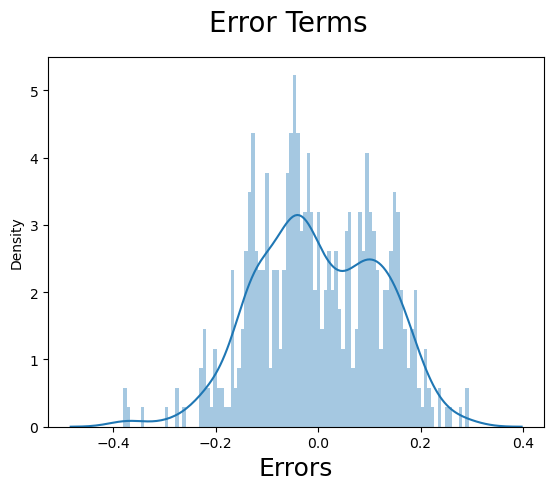

In [872]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 100)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label
plt.show()

#### Observation/s
- the distribution almost looks like a normal distribution but still not perfect

## Step 7: Making Predictions Using the Final Model

Now that we have fitted the model and checked the normality of error terms, it's time to go ahead and make predictions using the final model.


Important points

- In real situations we don't have min, max of test set values. We don't have a test data set. So the scaling method can't be done. 
- we never use the fit method on the test set. 
- fit on data: on the training data set. 
- transform(): test data set
- fit_transform()

In [873]:
# Applying the scaling on the test sets

num_vars = [ 'windspeed', 'casual', 'cnt']
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [874]:
# Dividing into X_test and y_test

y_test = df_test.pop('cnt')
X_test = df_test


In [875]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [876]:
# Making predictions
y_pred = lm.predict(X_test_new)

Text(0, 0.5, 'y_pred')

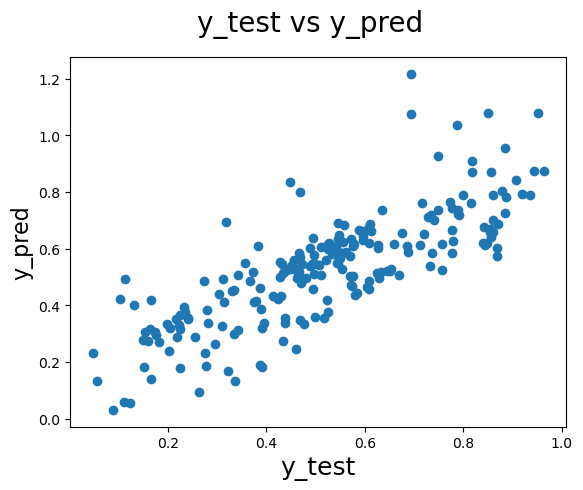

In [877]:
## Model Evaluation

# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label


In [878]:
#### Final Model Equation

In [ ]:
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.3739      0.012     30.691      0.000       0.350       0.398
casual                    0.9024      0.037     24.167      0.000       0.829       0.976
mnth_Aug                  0.0302      0.019      1.584      0.114      -0.007       0.068
mnth_Feb                 -0.0789      0.024     -3.355      0.001      -0.125      -0.033
mnth_Jan                 -0.1085      0.022     -5.003      0.000      -0.151      -0.066
mnth_Mar                 -0.0768      0.019     -4.058      0.000      -0.114      -0.040
mnth_Nov                  0.0203      0.020      1.009      0.314      -0.019       0.060
mnth_Sep                  0.0414      0.021      2.015      0.044       0.001       0.082
weekday_Mon              -0.2477      0.018    -14.014      0.000      -0.282      -0.213
weekday_Sun              -0.2328      0.018    -13.269      0.000      -0.267      -0.198
weathersit_Light Snow    -0.1425      0.033     -4.373      0.000      -0.207      -0.078


We can see that the equation of our best fitted line is:

Demand = 0.374 + 0.9 X Casual + 0.03 X mnth_Aug -0.079 X mnth_Feb -0.1085 X mnth_Jan -0.0768 X mnth_Mar + 0.0203 X mnth_Nov +  0.0414 X mnth_Sep -0.2477 X weekday_Mon -0.2328 X weekday_Sun -0.1425 X weathersit_Light Snow


### Observations and insights

- Casual has the highest coefficient and can bring in the most impact. 
- The top four variables are 
    - Casual, weekday_Mon, weekday_Sun, weathersit_Light Snow
- Categorical variables have a low to medium impact on the regression model. Though 9 out of 10 independent variables are categorical in our linearregressionmodel, the highest weightage is associated with Casual variable which is not a categorical variable.
- Sunday and Monday have higher impact on the demand as compared to other categorical variables such as different months and weather_light_Snow